In [4]:
import pycaret
import pandas as pd

In [5]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [6]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [7]:
data.tail()

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature
timestamp,,,,,
2025-02-07 07:00:00,70.933952,34.743259,29.321219,26.166471,28.271927
2025-02-08 07:00:00,69.348548,30.654249,26.000000,22.380675,28.385596
2025-02-09 07:00:00,69.916384,28.971065,24.616898,20.976852,28.373742
2025-02-10 07:00:00,71.226336,30.652667,25.856981,22.374574,28.251201
2025-02-11 07:00:00,68.159624,32.532955,27.522727,24.120455,28.693799


In [8]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [9]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [10]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [11]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [12]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [13]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [14]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [15]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [16]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [17]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# rolling_size = 1
# for i in range(2,rolling_size+1):
#     data[f'pm_2_5_rolling_{i}'] = data['pm_2_5'].rolling(window=i).mean().shift(1)

lag_size = 30
for i in range(1,lag_size+1):
    data[f'pm_2_5_lag_{i}'] = data['pm_2_5'].shift(i)

# data['humidity_rolling_2'] = data['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
# data['humidity_rolling_5'] = data['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
# data['humidity_rolling_7'] = data['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_7'] = data['humidity'].shift(7)

# data['temperature_rolling_2'] = data['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
# data['temperature_rolling_5'] = data['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
# data['temperature_rolling_7'] = data['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_7'] = data['temperature'].shift(7)

In [18]:
# data["temp_diff"] = data["temperature"].diff()
# data["humidity_diff"] = data["humidity"].diff()

In [19]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'pm_2_5_lag_8',
       'pm_2_5_lag_9', 'pm_2_5_lag_10', 'pm_2_5_lag_11', 'pm_2_5_lag_12',
       'pm_2_5_lag_13', 'pm_2_5_lag_14', 'pm_2_5_lag_15', 'pm_2_5_lag_16',
       'pm_2_5_lag_17', 'pm_2_5_lag_18', 'pm_2_5_lag_19', 'pm_2_5_lag_20',
       'pm_2_5_lag_21', 'pm_2_5_lag_22', 'pm_2_5_lag_23', 'pm_2_5_lag_24',
       'pm_2_5_lag_25', 'pm_2_5_lag_26', 'pm_2_5_lag_27', 'pm_2_5_lag_28',
       'pm_2_5_lag_29', 'pm_2_5_lag_30', 'humidity_lag_1', 'humidity_lag_2',
       'humidity_lag_3', 'humidity_lag_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', '

In [20]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

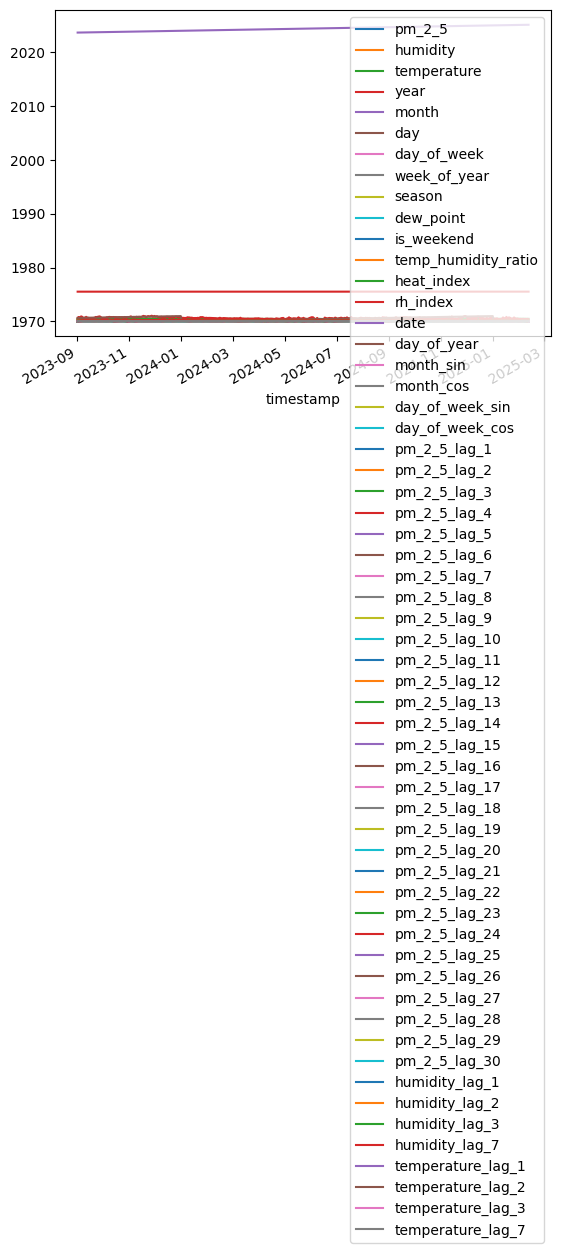

In [21]:
data_filtered.plot()

In [22]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [23]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [24]:
train_data.shape

(500, 58)

In [25]:
test_data.shape

(30, 58)

In [26]:
test_data.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,42.594631,78.292202,25.997341,2025,1,13,0,3,2,21.655782,...,9.330097,16.010753,85.379806,73.568381,70.491487,72.844643,25.434972,28.357459,28.945704,28.825509


In [27]:
test_data.tail(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,42.594631,34.02521,71.226336,69.916384,69.348548,70.266522,28.251201,28.373742,28.385596,27.775432


In [28]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,33.810780,35.536756,69.511783,71.500943,70.266522,68.520368,28.579177,28.327450,27.775432,27.336718
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,37.291228,33.810780,70.933952,69.511783,71.500943,69.231031,28.271927,28.579177,28.327450,27.315410
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,40.511737,37.291228,69.348548,70.933952,69.511783,70.341639,28.385596,28.271927,28.579177,27.683890
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,34.025210,40.511737,69.916384,69.348548,70.933952,65.114261,28.373742,28.385596,28.271927,28.644544
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,42.594631,34.025210,71.226336,69.916384,69.348548,70.266522,28.251201,28.373742,28.385596,27.775432


In [29]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'pm_2_5_lag_8',
       'pm_2_5_lag_9', 'pm_2_5_lag_10', 'pm_2_5_lag_11', 'pm_2_5_lag_12',
       'pm_2_5_lag_13', 'pm_2_5_lag_14', 'pm_2_5_lag_15', 'pm_2_5_lag_16',
       'pm_2_5_lag_17', 'pm_2_5_lag_18', 'pm_2_5_lag_19', 'pm_2_5_lag_20',
       'pm_2_5_lag_21', 'pm_2_5_lag_22', 'pm_2_5_lag_23', 'pm_2_5_lag_24',
       'pm_2_5_lag_25', 'pm_2_5_lag_26', 'pm_2_5_lag_27', 'pm_2_5_lag_28',
       'pm_2_5_lag_29', 'pm_2_5_lag_30', 'humidity_lag_1', 'humidity_lag_2',
       'humidity_lag_3', 'humidity_lag_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', '

In [30]:
# train_data.dropna()

In [31]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(500, 58)"
4,Transformed data shape,"(482, 60)"
5,Transformed train set shape,"(332, 60)"
6,Transformed test set shape,"(150, 60)"
7,Numeric features,56
8,Date features,1
9,Preprocess,True


In [32]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,5.1032,45.0624,6.5731,0.5125,0.3462,0.3263,0.0200
ada,AdaBoost Regressor,5.3761,47.2899,6.7359,0.4982,0.3662,0.3666,0.0458
et,Extra Trees Regressor,5.3166,47.0982,6.7073,0.4947,0.3558,0.3473,0.0692
br,Bayesian Ridge,5.2175,46.0613,6.6755,0.4940,0.3555,0.3339,0.0208
llar,Lasso Least Angle Regression,5.1859,46.1156,6.6666,0.4932,0.3515,0.3304,0.0233
lasso,Lasso Regression,5.1918,46.1861,6.6718,0.4921,0.3530,0.3311,0.0233
lightgbm,Light Gradient Boosting Machine,5.3497,47.4178,6.7619,0.4918,0.3641,0.3464,0.0775
huber,Huber Regressor,5.2434,46.7648,6.7077,0.4917,0.3537,0.3187,0.0250
gbr,Gradient Boosting Regressor,5.3472,47.0763,6.7685,0.4838,0.3586,0.3450,0.0767
en,Elastic Net,5.2183,46.6786,6.7185,0.4830,0.3578,0.3323,0.0233


In [33]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5868,29.1110,5.3955,0.6798,0.3209,0.3131
1,7.8401,108.8342,10.4324,0.4004,0.4171,0.3779
2,4.2693,23.9117,4.8900,0.6733,0.3680,0.4087
3,6.1253,55.9986,7.4832,0.5015,0.4202,0.4539
4,4.7035,54.5073,7.3829,0.4757,0.2946,0.2219
5,5.2350,44.9730,6.7062,0.2504,0.4015,0.4170
6,6.0137,53.2879,7.2999,0.1294,0.3872,0.4087
7,6.1053,53.3386,7.3033,0.5802,0.3857,0.4083
8,5.1172,38.5593,6.2096,0.5028,0.3215,0.3139


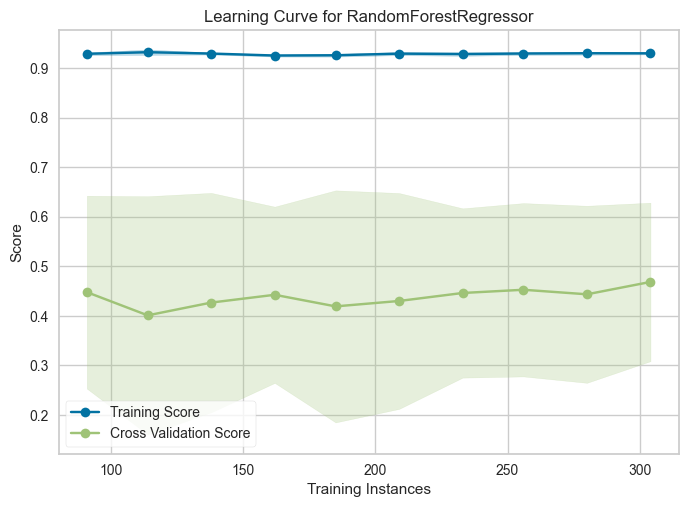

In [34]:
exp1.plot_model(model_1, 'learning')

In [35]:
# exp1.evaluate_model(model_1)

In [36]:
model_2 = exp1.create_model('ada')
model_3 = exp1.create_model('lightgbm')
model_4 = exp1.create_model('br')
model_5 = exp1.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.9705,35.9462,5.9955,0.6046,0.3446,0.3444
1,7.8980,115.9229,10.7667,0.3614,0.4351,0.3911
2,4.3182,26.2535,5.1238,0.6413,0.3976,0.4431
3,6.3881,56.0219,7.4848,0.5013,0.4516,0.5163
4,5.0537,53.3611,7.3049,0.4867,0.3056,0.2553
5,5.1493,37.7545,6.1445,0.3707,0.3903,0.4202
6,5.6329,48.6430,6.9745,0.2053,0.3996,0.4192
7,4.9055,42.6619,6.5316,0.6642,0.3736,0.3510
8,5.6169,42.1187,6.4899,0.4569,0.3422,0.3517


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.9620,34.5544,5.8783,0.6199,0.3352,0.3283
1,7.7354,107.6814,10.3770,0.4068,0.4350,0.3700
2,4.2787,30.1057,5.4869,0.5886,0.3969,0.4127
3,6.0180,59.7898,7.7324,0.4678,0.4317,0.4435
4,5.4810,56.7273,7.5318,0.4544,0.2984,0.2573
5,4.7969,34.8627,5.9045,0.4189,0.3668,0.3709
6,5.9995,53.4559,7.3114,0.1267,0.3905,0.4027
7,5.1246,41.8534,6.4694,0.6706,0.3757,0.3623
8,5.2491,44.6606,6.6829,0.4241,0.3444,0.3132


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.3544,29.6799,5.4479,0.6736,0.2904,0.2734
1,7.3250,93.3981,9.6643,0.4855,0.4023,0.3677
2,4.2920,26.9578,5.1921,0.6316,0.3343,0.3486
3,5.5359,44.7461,6.6893,0.6017,0.3651,0.3902
4,5.4724,65.0422,8.0649,0.3744,0.3516,0.2704
5,5.4082,47.6571,6.9034,0.2056,0.4237,0.4389
6,5.7949,53.2133,7.2947,0.1306,0.3762,0.3750
7,5.3927,42.7875,6.5412,0.6633,0.3599,0.3618
8,5.0585,39.9781,6.3228,0.4845,0.3083,0.2864


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.6738,31.8957,5.6476,0.6492,0.3331,0.3216
1,7.9465,116.7318,10.8043,0.3569,0.4186,0.3734
2,4.0331,22.6035,4.7543,0.6911,0.3623,0.3904
3,5.7170,47.0965,6.8627,0.5808,0.4035,0.4312
4,4.7086,51.2765,7.1608,0.5068,0.2895,0.2289
5,4.7792,37.6813,6.1385,0.3719,0.3914,0.3865
6,6.1715,58.4863,7.6476,0.0445,0.4138,0.4416
7,5.4591,47.0944,6.8625,0.6294,0.3735,0.3777
8,5.3914,42.9275,6.5519,0.4464,0.3277,0.3256


In [37]:
exp1.evaluate_model(model_3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [38]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_1, data=new_data)
predictions.head()

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,is_weekend,...,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,78.292206,25.997341,2025,1,13,0,3,2,21.655781,0,...,16.010754,85.379807,73.568382,70.491486,72.844643,25.434973,28.357460,28.945705,28.825508,30.814896
2025-01-14 07:00:00,74.887207,26.780884,2025,1,14,1,3,2,21.758324,0,...,9.330097,78.292206,85.379807,73.568382,70.630295,25.997341,25.434973,28.357460,29.145098,34.742229
2025-01-15 07:00:00,74.201401,27.146723,2025,1,15,2,3,2,21.987003,0,...,3.025287,74.887207,78.292206,85.379807,71.168640,26.780884,25.997341,25.434973,28.921543,37.110592
2025-01-16 07:00:00,89.873428,24.990604,2025,1,16,3,3,2,22.965288,0,...,3.617924,74.201401,74.887207,78.292206,70.983574,27.146723,26.780884,25.997341,28.383165,35.261879
2025-01-17 07:00:00,80.848938,27.221664,2025,1,17,4,3,2,23.391453,0,...,14.572545,89.873428,74.201401,74.887207,70.491486,24.990604,27.146723,26.780884,28.945705,35.209860


In [39]:
predict_v = predictions['prediction_label']
predict_v.head()

timestamp
2025-01-13 07:00:00    30.814896
2025-01-14 07:00:00    34.742229
2025-01-15 07:00:00    37.110592
2025-01-16 07:00:00    35.261879
2025-01-17 07:00:00    35.209860
Freq: D, Name: prediction_label, dtype: float64

In [40]:
real = test_data['pm_2_5']
# real.head(7)

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

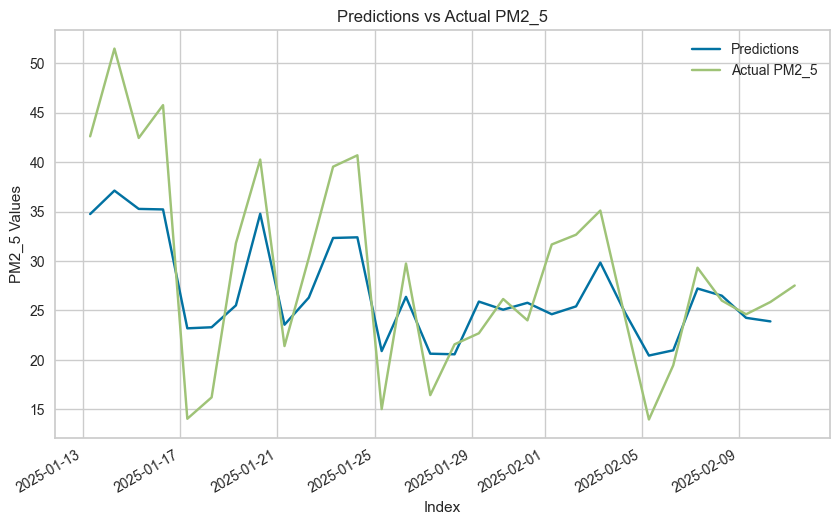

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

In [42]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data["pm_2_5"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: 0.6416
Mean Absolute Error (MAE): 4.9264
Root Mean Squared Error (RMSE): 5.9763
Accuracy: 82.90%


In [43]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["pm_2_5"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.6416
Mean Absolute Error (MAE): 4.9264
Root Mean Squared Error (RMSE): 5.9763
Mean Absolute Percentage Error (MAPE): 18.25%
Accuracy: 81.75%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [44]:
# model_1 = exp1.create_model('rf')
# tune_1 = exp1.tune_model(model_1)

In [45]:
exp1.save_model(model_1, "pm2_5_model_1")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature', 'year',
                                              'month', 'day', 'day_of_week',
                                              'week_of_year', 'season',
                                              'dew_point', 'is_weekend',
                                              'temp_humidity_ratio',
                                              'heat_index', 'rh_index'...
                                              'pm_2_5_lag_8', 'pm_2_5_lag_9',
                                              'pm_2_5_lag_10', 'pm_2_5_lag_11',
                                              'pm_2_5_lag_12', ...],
                                     transformer=SimpleImputer())),
   

In [46]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_1

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    # rolling_size = 1
    # for i in range(1,rolling_size+1):
    #     data_compare[f'pm_2_5_rolling_{i}'] = data_compare['pm_2_5'].rolling(window=i).mean().shift(1)

    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

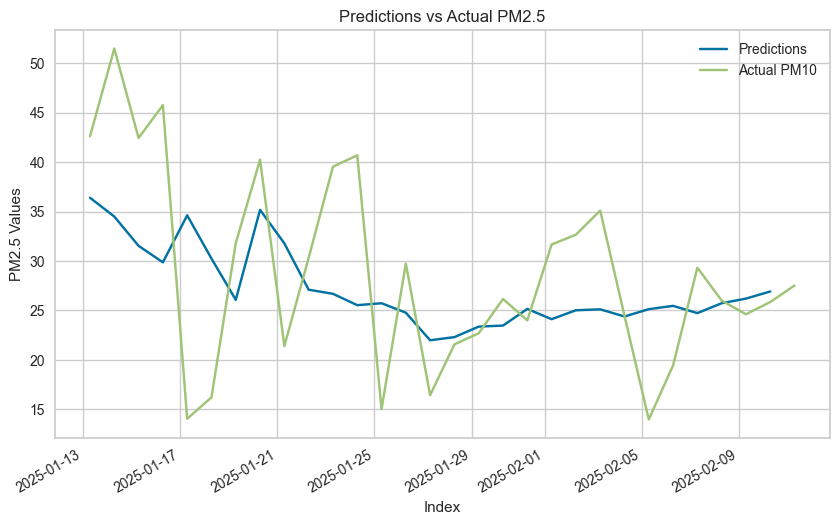

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [48]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = real_data["pm_2_5"][:"2025-2-10"]
y_pred = result['prediction_label'].shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: 0.1466
Mean Absolute Error (MAE): 7.3529
Root Mean Squared Error (RMSE): 9.2223
Accuracy: 74.47%


In [49]:
# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.1466
Mean Absolute Error (MAE): 7.3529
Root Mean Squared Error (RMSE): 9.2223
Mean Absolute Percentage Error (MAPE): 29.54%
Accuracy: 70.46%


In [77]:
y_true_7 = real_data["pm_2_5"][:"2025-1-26"]
y_pred_7 = (result['prediction_label'].shift(-1).dropna(axis=0))[:'2025-1-26']# "prediction_label" contains predictions

In [78]:
y_true_7.shape

(14,)

In [80]:
# Calculate Regression Metrics
r2 = r2_score(y_true_7, y_pred_7)
mae = mean_absolute_error(y_true_7, y_pred_7)
rmse = np.sqrt(mean_squared_error(y_true_7, y_pred_7))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true_7 - y_pred_7) / y_true_7)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -0.0366
Mean Absolute Error (MAE): 10.8974
Root Mean Squared Error (RMSE): 12.0306
Mean Absolute Percentage Error (MAPE): 41.98%
Accuracy: 58.02%


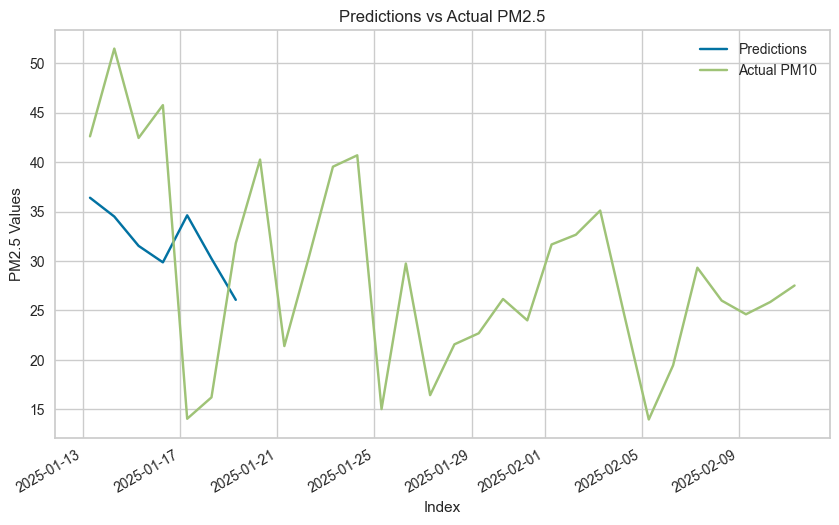

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([((result['prediction_label'].shift(-1))[:'2025-1-19']), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()